# Point Cluster Context

The `PointClusterContext` class is used to cluster cells of a given type and delineating the cells belonging to the clusters. Here we will use it to cluster immune cells to get a hang of how the immune cells are clustered within the stroma.

After fititng the context, The `PointClusterContext.context` attribute will contain a nested dict where each value is a dict contain the following key-value pairs:

- `roi_area` - the alpha shape of the cluster (`gpd.GeoDataFrame`)
- `roi_cells` - the cells inside the the alpha shape of the cluster. (`gpd.GeoDataFrame`)
- `roi_grid` - the grids fitted on top of the cluster areas. (`gpd.GeoDataFrame`)
- `roi_network` - the network fitted on the `roi_cells`. (`libpysal.weights.W`)

## Fitting the Context

In [1]:
from cellseg_gsontools.data import cervix_cells
from cellseg_gsontools.spatial_context import PointClusterContext

# Create a WithinContext object
pcsp = PointClusterContext(
    cell_gdf=cervix_cells(),
    labels="inflammatory",  # Cluster the inflammatory cells
    cluster_method="dbscan",  # Use DBSCAN for clustering
    min_area_size=50000,  # Discard clusters that are smaller than this
    parallel=False,  # Whether to run in parallel
    num_processes=1,  # Number of processes to use
    graph_type="distband",  # Use a distance band graph (distance thresholded KNN-graph)
    dist_thresh=75,  # Distance threshold for the graph (in pixels)
    backend="geopandas",  # Use geopandas for fitting
    grid_type="hex",  # Use a hexagonal grid
    resolution=10,  # Resolution of the grid,
    min_samples=60,  # Minimum number of samples for DBSCAN
)
pcsp.fit(fit_grid=True, fit_graph=True)

Processing roi area: 2: 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


In [2]:
# Cells of the first cluster
pcsp.context[0]["roi_cells"].head()

,type,geometry,class_name,global_id,spatial_context_id,spatial_context
global_id,,,,,,
4806,Feature,"POLYGON ((4865.01188 48778.00360, 4865.01188 4...",inflammatory,4806,0,inflammatory
4810,Feature,"POLYGON ((4966.01150 48787.01150, 4966.01191 4...",connective,4810,0,inflammatory
4819,Feature,"POLYGON ((4891.01188 48828.99640, 4893.01013 4...",connective,4819,0,inflammatory
4830,Feature,"POLYGON ((4932.01191 48840.00298, 4932.01191 4...",inflammatory,4830,0,inflammatory
4837,Feature,"POLYGON ((4868.01182 48855.00490, 4868.01182 4...",connective,4837,0,inflammatory


## Plotting the clusters

Let's plot the immune cell clusters.

<Axes: >

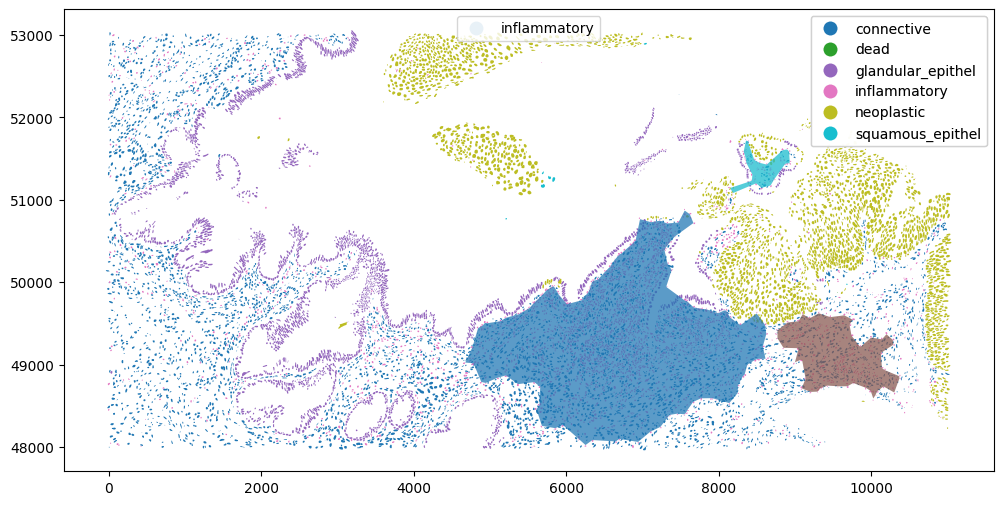

In [3]:
pcsp.plot("roi_area", figsize=(12, 6))

<Axes: >

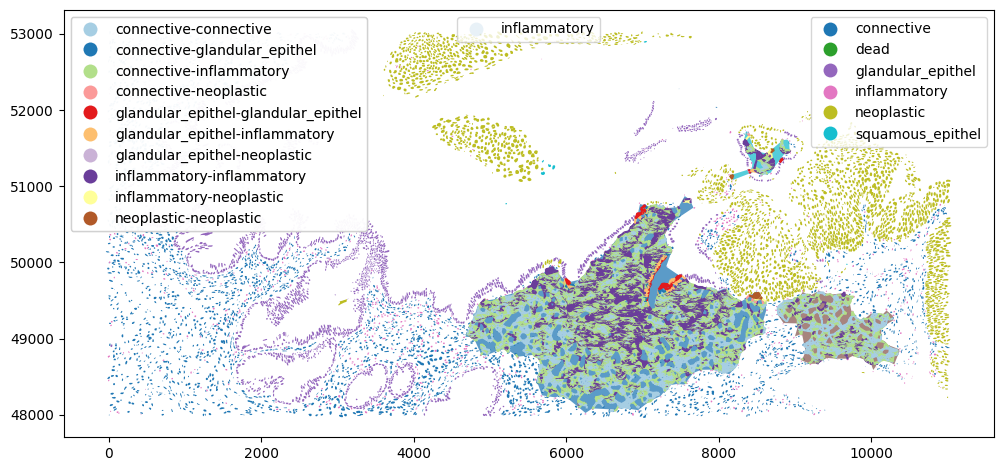

In [4]:
pcsp.plot("roi_area", network_key="roi_network", figsize=(12, 6))

<Axes: >

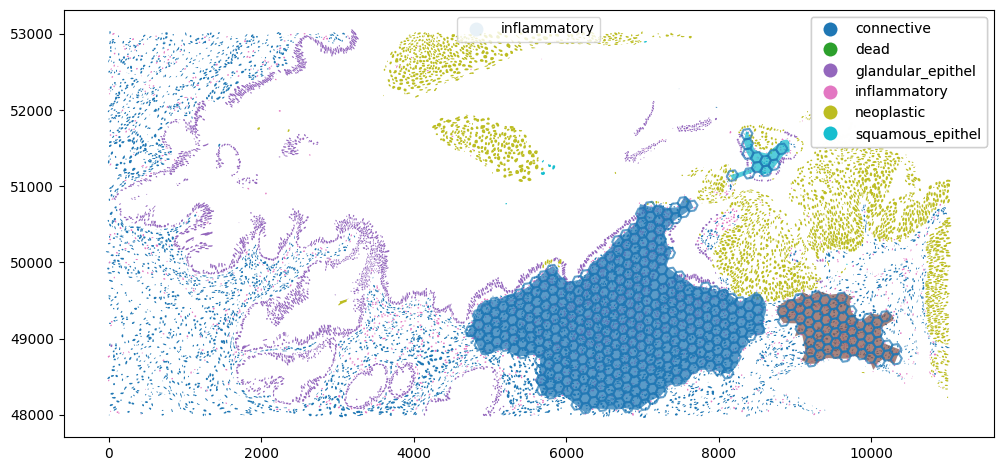

In [5]:
pcsp.plot("roi_area", grid_key="roi_grid", figsize=(12, 6))

## Downstream Analysis
Now that we've fitted the context, we can use the clusters in the `context` class attribute to compute more cell level features for the clustered cells. Here, we will showcase some lightweight downstream analyses for the clustered cells.

### Example 1: Immune Cell Density
Now, if we wanted to compute the density of the inflammatory cells within one of the clusters, we could use the `roi_grid` key of the context and compute the cell count of the inflammatory cells within the grid cells.

<Axes: >

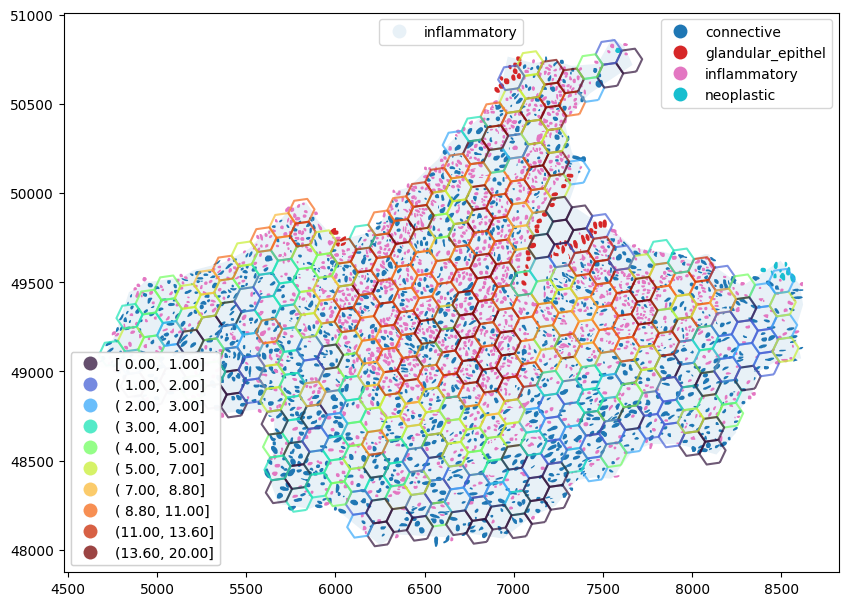

In [6]:
import geopandas as gpd
import mapclassify

from cellseg_gsontools.grid import grid_classify
from cellseg_gsontools.plotting import plot_all


# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


# Immune cell cnt heuristic to classify the grid cells into two classes
def get_immune_cell_cnt(gdf: gpd.GeoDataFrame, **kwargs) -> int:
    try:
        cnt = gdf.class_name.value_counts()["inflammatory"]
    except KeyError:
        cnt = 0

    return int(cnt)


# Count the immune cells within the grid cells with the cell cnt heuristic
tumor_grid = grid_classify(
    grid=pcsp.context[0]["roi_grid"],
    objs=pcsp.context[0]["roi_cells"],
    metric_func=get_immune_cell_cnt,
    predicate="intersects",
    new_col_names="immune_cnt",
    parallel=False,
)

# bin the grid cells into two classes ("has immune cells" and "no immune cells")
col = "immune_cnt"
bins = mapclassify.Quantiles(tumor_grid[col], k=10)
tumor_grid["immune_density_level"] = bins.yb

immune_density_plot = plot_all(
    pcsp.context[0]["roi_area"],
    pcsp.context[0]["roi_cells"],
    grid_gdf=tumor_grid.copy(),
    figsize=(10, 10),
    grid_col="immune_density_level",
    grid_cmap="turbo",
    grid_n_bins=bins.k,
    show_legends=True,
)
mapping = dict([(i, s) for i, s in enumerate(bins.get_legend_classes())])
replace_legend_items(immune_density_plot.get_legend(), mapping)
immune_density_plot

We can see that the density of the inflammatory cells is higher in the upper part of the cluster. This could be avoided by adjusting the dbscan parameters (especially `min_samples`).

### Example 2: Comparing Morphological Features of the Immune Cells Between Clusters

Next, we will compute some basic morphological metrics for the inflammatory cell shapes in all of the clusters.

In [7]:
from cellseg_gsontools.geometry import shape_metric

gdf = pcsp.context2gdf("roi_cells")
immune_cells = gdf.loc[gdf.class_name == "inflammatory"]  # only neoplastic cells

# morphological metrics to compute
metrics = [
    "area",
    "eccentricity",
    "solidity",
    "circularity",
    "sphericity",
    "compactness",
    "elongation",
    "fractal_dimension",
    "shape_index",
]
immune_cells = shape_metric(
    immune_cells,
    metrics=metrics,
    parallel=True,
)

cols = [
    "geometry",
    "global_id",
    "class_name",
    "spatial_context_id",
    "area",
    "eccentricity",
    "solidity",
    "circularity",
    "sphericity",
    "compactness",
    "elongation",
    "fractal_dimension",
    "shape_index",
]
immune_cells = immune_cells[cols]
immune_cells.head()

,geometry,global_id,class_name,spatial_context_id,area,eccentricity,solidity,circularity,sphericity,compactness,elongation,fractal_dimension,shape_index
0,"POLYGON ((4865.01188 48778.00360, 4865.01188 4...",4806,inflammatory,0,386.718486,0.755237,0.993871,0.877937,0.596791,0.876128,0.958292,0.755237,0.821274
3,"POLYGON ((4932.01191 48840.00298, 4932.01191 4...",4830,inflammatory,0,396.938416,0.484353,0.993323,0.910579,0.646786,0.908666,0.874873,0.484353,0.850914
8,"POLYGON ((4876.01188 48927.00360, 4876.01188 4...",4856,inflammatory,0,154.498343,0.371447,1.000000,0.955547,0.709712,0.955547,0.928459,0.371447,0.995403
15,"POLYGON ((4755.01182 49005.99510, 4759.00677 4...",4890,inflammatory,0,708.135914,0.843131,0.934173,0.757398,0.457822,0.744883,0.674798,0.843131,0.745539
17,"POLYGON ((4833.01188 49016.00360, 4833.01191 4...",4897,inflammatory,0,376.063088,0.563807,1.000000,0.941260,0.662142,0.941260,0.825907,0.563807,0.905558


Let's Now tidy up the data (convert from wide format to long format) to compare the morphological features between the clusters.

In [8]:
m = list(metrics)
tidy = immune_cells.reset_index().set_index("spatial_context_id")
tidy = tidy[m]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={"spatial_context_id": "Label", "level_1": "Attribute", 0: "Values"}
)
tidy

,Label,Attribute,Values
0,0,area,386.718486
1,0,eccentricity,0.755237
2,0,solidity,0.993871
3,0,circularity,0.877937
4,0,sphericity,0.596791
...,...,...,...
19588,2,sphericity,0.664356
19589,2,compactness,0.891418
19590,2,elongation,0.933351
19591,2,fractal_dimension,0.358986


In [9]:
# Install seaborn for plotting in the next cell
# !pip install seaborn

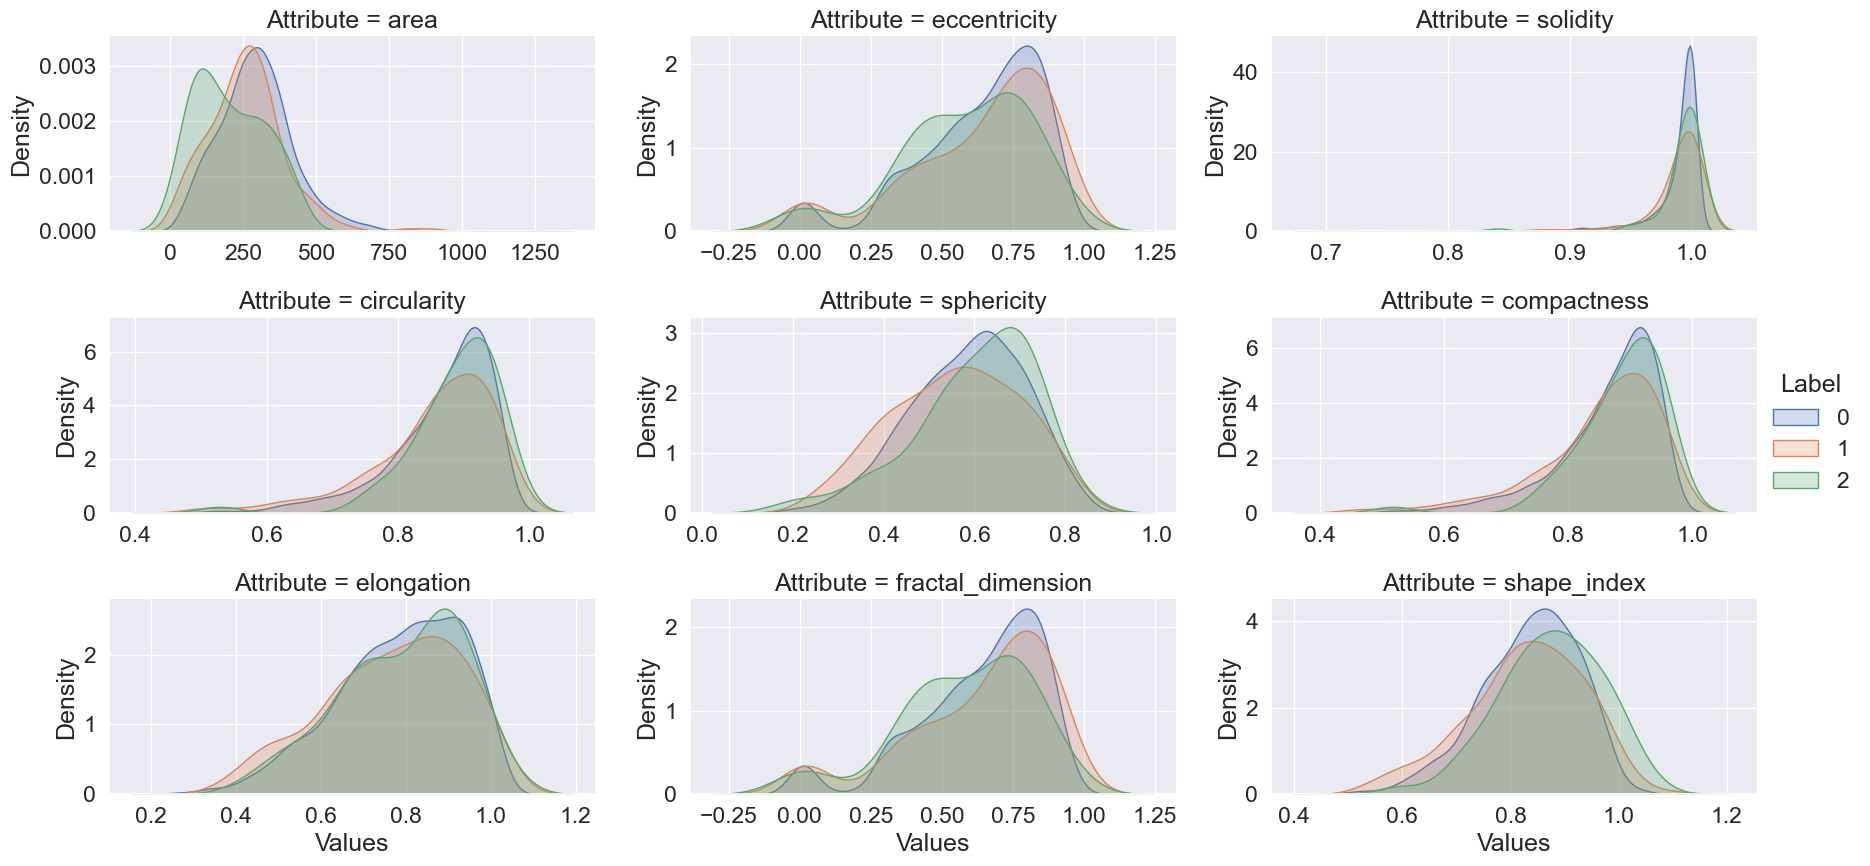

In [10]:
import seaborn

seaborn.set_style("whitegrid")
seaborn.set(font_scale=1.5)

# Setup the facets
facets = seaborn.FacetGrid(
    data=tidy,
    col="Attribute",
    hue="Label",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)

# Build the plot from `sns.kdeplot`
kde_ax = facets.map(seaborn.kdeplot, "Values", fill=True).add_legend()

We can see that the morphological features are distributed quite similarly between the clusters. The only feature that seems to be different is the `area` feature. This is likely due to the different sizes and the number of immune cells contained in the clusters. 